In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline
from IPython import display
import tensorflow as tf
import tensorflow_probability as tfp



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
import os
import glob

In [58]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [255]:
def train(x_train, y_train, batch_size, n_layers, n_units, iters=100):
    tf.reset_default_graph()
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.shuffle(buffer_size=len(x_train))
    ds = ds.repeat()
    #ds = ds.apply(tf.data.experimental.map_and_batch(map_func=tf.keras.layers.Flatten(),
    #                                             batch_size=batch_size, num_parallel_batches=4))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=20*batch_size)
    iterator = ds.make_one_shot_iterator()
    
    x, y = iterator.get_next()
    y = tf.one_hot(y, 10)
    errors_tf, accuracy_tf = fwbw(x, y, batch_size, n_layers, n_units)
    errors_tf = tf.reduce_sum(errors_tf)

    errors_a = []
    accuracy_a = []
    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        for iter_i in range(iters + 1):
            errors, accuracy = sess.run([errors_tf, accuracy_tf])
            if iter_i % 1000 == 0:
                print("\r%d/%d %.2f %.2f" % (iter_i, iters, errors, accuracy), end="", flush=True)
                errors_a.append(errors)
                accuracy_a.append(accuracy)                                
        print()
    return(errors_a, accuracy_a)

In [256]:
errors, accuracy = train(x_train, y_train, 64, n_layers=1, n_units=1024, iters=1000000)

1000000/1000000 2.31 0.00


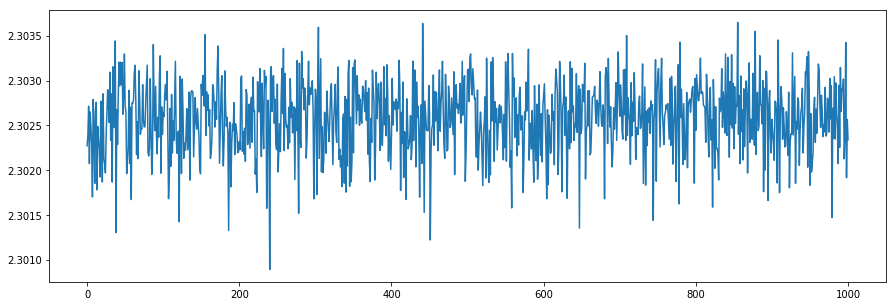

In [252]:
plt.figure(figsize=(15,5))
#plt.xlim((-1.5, 1.5))
#plt.ylim((-1.5, 1.5))
plt.plot(errors)
plt.show()
#plt.title("%d / %d" % (cur_iter, i))
#fig = plt.gcf()
#fig.savefig("/publicwork/mhe/Peano/%s/peano_%d_%08d.png" % (plot_dir, i, cur_iter), bbox_inches='tight')
#plt.close(fig)

In [242]:
from tensorflow.contrib import layers
    
def fwbw(x, y, batch_size, n_layers=2, n_units=100):
    
    inputs = []
    outputs = []
    ws = []
    
    x = tf.keras.layers.Flatten()(x)
    
    for i in range(n_layers):
        out_units = n_units
        if i == 0:
            in_units= 28*28 + 1
        else:
            in_units = n_units + 1
        if i == n_layers - 1:
            out_units = 10
        x = tf.concat([x, tf.ones([batch_size, 1])], 1) # bias        
        inputs.append(x)
        w = tf.get_variable("dense.kernel.%d" % i, [in_units, out_units],
                            tf.float32, initializer=tf.initializers.orthogonal,
                            trainable=False)
        x = tf.matmul(x, w, name="dense.%d" % i)
        x = tf.nn.relu(x)
        outputs.append(x)
        ws.append(w)
    outputs[-1] = y

    x = tf.nn.softmax(x)
    errors = tf.losses.softmax_cross_entropy(y, x)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y, x), tf.float32))
    
    for i in range(n_layers):
        delta_w = tf.matmul(tf.transpose(inputs[i]), outputs[i])
        ws[i] = ws[i] + delta_w
            
        
    return errors, accuracy
        

In [ ]:
pot_xy = ret_dict["sigmas_xy_mat"]
plt.figure(figsize=(15,15))
plt.imshow(pot_xy, origin='lower', cmap='hot')
plt.title("xy")
plt.colorbar()
#fig = plt.gcf()
#fig.savefig("plots_toy/gauss_xy.png", bbox_inches='tight')